# Diabetes Prediction - XGBoost

**Notebook Series**:
['1_eda.ipynb](./1_eda.ipynb) --> ['2_preprocessing.ipynb'](./2_preprocessing.ipynb) --> **3_XGBoost_model.ipynb**

# Libraries

In [397]:
import sys
import os
from pathlib import Path
from joblib import load

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline
from scipy.stats import ttest_ind
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve, average_precision_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, log_loss
import shap  
import time

# XGBoost

In [313]:
pipeline_xgb = Pipeline(steps=[
    ('preprocessor',preprocessor_pipeline),
    ('xgb',XGBClassifier(scale_pos_weight=2,random_state=42))
])

pipeline_xgb

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('impute',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    remainder='passthrough',
                                                    transformers=[('impute',
                                                                   SimpleImputer(strategy='median'),
                                                                   ['Glucose',
                                                                    'BloodPressure',
                                                                    'SkinThickness',
                                                                    'Insulin',
                                                                    'BMI'])],
                                                    verbose_feature_names_out=False)),
                                 ('add_interaction', AddInteractionFeatures()),
                                 ('bin_features', BinFe...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

## Performance metrics

In [193]:
model_xgb = pipeline_xgb.fit(X_train,y_train)

y_train_pred_xgb = model_xgb.predict(X_train)
y_test_pred_xgb = model_xgb.predict(X_test)

y_train_proba_xgb = model_xgb.predict_proba(X_train)
y_test_proba_xgb = model_xgb.predict_proba(X_test)

In [314]:
# AUC scores for the default XGB classifier

print('AUC scores, XGB classfication model with default hyperparameters')
print(f'\ntrain data: {roc_auc_score(y_train,y_train_proba_xgb[:,1]):.3f}')
print(f'test data: {roc_auc_score(y_test,y_test_proba_xgb[:,1]):.3f}')

AUC scores, XGB classfication model with default hyperparameters

train data: 1.000
test data: 0.770


## Hyperparameter tuning with gridsearch

In [538]:
# perform a Grid search to find the best hyperparameters for the XGBoost model 

parameters_xgb = {
    'xgb__n_estimators':[34],
    'xgb__max_depth':[2],
    'xgb__learning_rate':[0.025],
    'xgb__min_child_weight':[10],
    'xgb__subsample':[0.45],
    'xgb__colsample_bytree':[0.7],
    'xgb__gamma':[0.15],
    'xgb__reg_alpha':[0.3],
    'xgb__reg_lambda':[0.65],
    'xgb__scale_pos_weight':[2],
    'xgb__random_state':[42]
}    

cv = StratifiedKFold(n_splits=5)

# perform grid search with cross-validation
gs_xgb = GridSearchCV(estimator=pipeline_xgb,param_grid=parameters_xgb,
                          cv=cv,scoring='roc_auc',n_jobs=-1,verbose=1)

# get the start time
start_time = time.time()

# fit the grid search on the training data
gs_xgb.fit(X_train,y_train)

# get the end and elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# best score and parameters
best_aucscore_xgb = gs_xgb.best_score_
best_parameters_xgb = gs_xgb.best_params_
best_model_xgb = gs_xgb.best_estimator_

print(f'\nXGB AUC score: {best_aucscore_xgb:.3f}')
print(f'\nXGB best parameters: \n{best_parameters_xgb}')

print(f'\nelapsed_time (sec): {elapsed_time:.2f} seconds')
print(f'elapsed_time (min): {(elapsed_time)/60:.2f} minutes')

Fitting 5 folds for each of 1 candidates, totalling 5 fits

XGB AUC score: 0.851

XGB best parameters: 
{'xgb__colsample_bytree': 0.7, 'xgb__gamma': 0.15, 'xgb__learning_rate': 0.025, 'xgb__max_depth': 2, 'xgb__min_child_weight': 10, 'xgb__n_estimators': 34, 'xgb__random_state': 42, 'xgb__reg_alpha': 0.3, 'xgb__reg_lambda': 0.65, 'xgb__scale_pos_weight': 2, 'xgb__subsample': 0.45}

elapsed_time (sec): 0.15 seconds
elapsed_time (min): 0.00 minutes


In [539]:
# apply the gridsearch best parameters for XGB model metrics

y_train_pred_xgb_gs = gs_xgb.predict(X_train)
y_test_pred_xgb_gs = gs_xgb.predict(X_test)

y_train_proba_xgb_gs = gs_xgb.predict_proba(X_train)
y_test_proba_xgb_gs = gs_xgb.predict_proba(X_test)

In [540]:
# AUC scores for XGB model with best parameters

print('AUC scores for the XGB model with best parameters')
print(f'\ntrain data: {roc_auc_score(y_train,y_train_proba_xgb_gs[:,1]):.3f}')
print(f'test data: {roc_auc_score(y_test,y_test_proba_xgb_gs[:,1]):.3f}')

AUC scores for the XGB model with best parameters

train data: 0.867
test data: 0.836


## Classification report - tuned XGB

In [541]:
print(f'classification report for tuned XGB model')

print(f'\ntrain data, XGB tuned: \n{classification_report(y_train,y_train_pred_xgb_gs)}')
print(f'\ntest data, XGB tuned: \n{classification_report(y_test,y_test_pred_xgb_gs)}')

classification report for tuned XGB model

train data, XGB tuned: 
              precision    recall  f1-score   support

           0       0.90      0.71      0.80       401
           1       0.61      0.85      0.71       213

    accuracy                           0.76       614
   macro avg       0.76      0.78      0.76       614
weighted avg       0.80      0.76      0.77       614


test data, XGB tuned: 
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        99
           1       0.59      0.85      0.70        55

    accuracy                           0.73       154
   macro avg       0.74      0.76      0.73       154
weighted avg       0.78      0.73      0.74       154



The hyperparameter tuned XGB model is moderately overfitting the data.  I will 
investigate feature importance and run the gridsearch again with a subset 
of features. 

## Feature importance

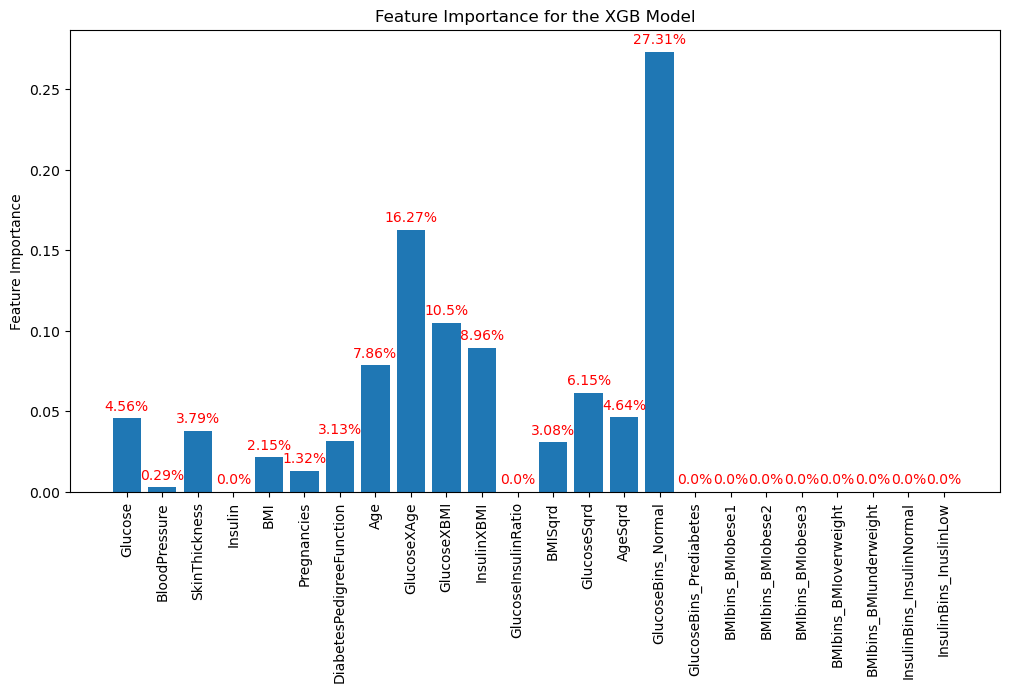

In [542]:
xgb_model = best_model_xgb.named_steps['xgb']
feature_importance_xgb = xgb_model.feature_importances_

plt.figure(figsize=(12,6))
plt.bar(transformed_data_df.columns,feature_importance_xgb)
plt.ylabel('Feature Importance')
plt.title('Feature Importance for the XGB Model')
plt.xticks(rotation=90)

for index,value in enumerate(feature_importance_xgb):
    plt.text(index, value+0.005,str((100*value).round(2))+'%',ha='center',color='red')

plt.show()

In [543]:
# set a threshold at 2% for features to remove

threshold = 0.02

important_features_xgb = [feature for feature, importance in zip(
    feature_names,feature_importance_xgb) if importance >= threshold]

print(f'features kept after applying the threshold: \n{important_features_xgb}')
print(f'\nnumber of features retained: {len(important_features_xgb)}')

features kept after applying the threshold: 
['Glucose', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'GlucoseXAge', 'GlucoseXBMI', 'InsulinXBMI', 'BMISqrd', 'GlucoseSqrd', 'AgeSqrd', 'GlucoseBins_Normal']

number of features retained: 12


In [544]:
# test the RF model again with the edited feature list

# Fit the pipeline on the training data and transform X_train
transformed_data_train = preprocessor_pipeline.fit_transform(X_train)

# Transform the test data using the fitted pipeline
transformed_data_test = preprocessor_pipeline.transform(X_test)

# Convert transformed data to DataFrame with feature names
transformed_data_train_df = pd.DataFrame(transformed_data_train, columns=feature_names)
transformed_data_test_df = pd.DataFrame(transformed_data_test, columns=feature_names)

# Extract important features based on the threshold
X_train_impfeats_xgb = transformed_data_train_df[important_features_xgb]
X_test_impfeats_xgb = transformed_data_test_df[important_features_xgb]

In [545]:
print(f'X_train_impfeats_xgb: \n{X_train_impfeats_xgb.columns}')
print(f'\nX_test_impfeats_xgb: \n{X_test_impfeats_xgb.columns}')

X_train_impfeats_xgb: 
Index(['Glucose', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age',
       'GlucoseXAge', 'GlucoseXBMI', 'InsulinXBMI', 'BMISqrd', 'GlucoseSqrd',
       'AgeSqrd', 'GlucoseBins_Normal'],
      dtype='object')

X_test_impfeats_xgb: 
Index(['Glucose', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age',
       'GlucoseXAge', 'GlucoseXBMI', 'InsulinXBMI', 'BMISqrd', 'GlucoseSqrd',
       'AgeSqrd', 'GlucoseBins_Normal'],
      dtype='object')


In [546]:
# fit the XGB model with the data set edited for important features

xgb = XGBClassifier(scale_pos_weight=2,random_state=42)

model_xgb2 = xgb.fit(X_train_impfeats_xgb,y_train)

# predict using the fitted model
y_train_pred_xgb2 = model_xgb2.predict(X_train_impfeats_xgb)
y_test_pred_xgb2 = model_xgb2.predict(X_test_impfeats_xgb)

# get the prediction probabilities
y_train_proba_xgb2 = model_xgb2.predict_proba(X_train_impfeats_xgb)
y_test_proba_xgb2 = model_xgb2.predict_proba(X_test_impfeats_xgb)

In [547]:
# AUC score for default random forest model fit with the edited data set

print('AUC scores for the XGB model fit with the edited dataset, default hyperparameters:')
print(f'train data: {roc_auc_score(y_train,y_train_proba_xgb2[:,1]):.3f}')
print(f'test data: {roc_auc_score(y_test,y_test_proba_xgb2[:,1]):.3f}')

AUC scores for the XGB model fit with the edited dataset, default hyperparameters:
train data: 1.000
test data: 0.771


## Hyperparameter tuning - important features

In [574]:
# perform a Grid search to find the best hyperparameters for the XGBoost model

parameters_xgb2 = {
    'n_estimators':[34],
    'max_depth':[2],
    'learning_rate':[0.025],
    'min_child_weight':[10],
    'subsample':[0.45],
    'colsample_bytree':[0.7],
    'gamma':[0.15],
    'reg_alpha':[0.3],
    'reg_lambda':[0.65],
    'scale_pos_weight':[2],
    'random_state':[42]
}    

cv = StratifiedKFold(n_splits=5)

# perform grid search with cross-validation
gs_xgb2 = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=parameters_xgb2,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# get the start time
start_time = time.time()

# fit the grid search on the training data
gs_xgb2.fit(X_train_impfeats_xgb,y_train)

# get the end and elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# best score and parameters
best_aucscore_xgb2 = gs_xgb2.best_score_
best_parameters_xgb2 = gs_xgb2.best_params_
best_model_xgb2 = gs_xgb2.best_estimator_

print(f'\nXGB AUC score: {best_aucscore_xgb2:.3f}')
print(f'\nXGB best parameters: \n{best_parameters_xgb2}')

print(f'\nelapsed time (sec): {elapsed_time:.2f} seconds')
print(f'elapsed time (min): {(elapsed_time)/60:.2f} minutes')

Fitting 5 folds for each of 1 candidates, totalling 5 fits

XGB AUC score: 0.844

XGB best parameters: 
{'colsample_bytree': 0.7, 'gamma': 0.15, 'learning_rate': 0.025, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 34, 'random_state': 42, 'reg_alpha': 0.3, 'reg_lambda': 0.65, 'scale_pos_weight': 2, 'subsample': 0.45}

elapsed time (sec): 2.03 seconds
elapsed time (min): 0.03 minutes


In [575]:
# AUC score for XGB model with best parameters on edited dataset

y_train_pred_xgb2_gs = gs_xgb2.predict(X_train_impfeats_xgb)
y_test_pred_xgb2_gs = gs_xgb2.predict(X_test_impfeats_xgb)

y_train_proba_xgb2_gs = gs_xgb2.predict_proba(X_train_impfeats_xgb)
y_test_proba_xgb2_gs = gs_xgb2.predict_proba(X_test_impfeats_xgb)

print('AUC scores for XGB model with edited features and best parameters')
print(f'train impfeats: {roc_auc_score(y_train,y_train_proba_xgb2_gs[:,1]):.3f}')
print(f'test impfeats: {roc_auc_score(y_test,y_test_proba_xgb2_gs[:,1]):.3f}')

AUC scores for XGB model with edited features and best parameters
train impfeats: 0.869
test impfeats: 0.831


The XGB model on the subset of important features performed the same as the XGB model on unedited features, with regards to the test set AUC score.  Also, the model on important features is overfitting comparitively.  

I will run the metrics here for both full and edited features for more convenient comparison.

## Classification report

In [576]:
# classification report, default and tuned XGB hyperparameters as well as 
# tuned XGB hyperparameters on the edited feature set.  

print(f'classification report for XGB models')

print(f'\ntrain data, XGB default: \n{classification_report(y_train,y_train_pred_xgb)}')
print(f'\ntest data, XGB default: \n{classification_report(y_test,y_test_pred_xgb)}')

print(f'\ntrain data, XGB tuned: \n{classification_report(y_train,y_train_pred_xgb_gs)}')
print(f'\ntest data, XGB tuned: \n{classification_report(y_test,y_test_pred_xgb_gs)}')

print(f'\ntrain data, XGB tuned, reduced complexity: \n{classification_report(y_train,y_train_pred_xgb2_gs)}')
print(f'\ntest data, XGB tuned, reduced complexity: \n{classification_report(y_test,y_test_pred_xgb2_gs)}')

classification report for XGB models

train data, XGB default: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       213

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614


test data, XGB default: 
              precision    recall  f1-score   support

           0       0.83      0.72      0.77        99
           1       0.59      0.73      0.65        55

    accuracy                           0.72       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.74      0.72      0.73       154


train data, XGB tuned: 
              precision    recall  f1-score   support

           0       0.90      0.71      0.80       401
           1       0.61      0.85      0.71       213

    accuracy                           0.76       614
   macro avg 

The hyperparameter tuned XGB models have good recall on the minority class of the test data set. 

While a high recall for predicting T2DM is the desired function for this model, the low precision suggests that the threshold for classifying an observation as either 0 or 1 needs to be optimized.  

## Confusion matrix

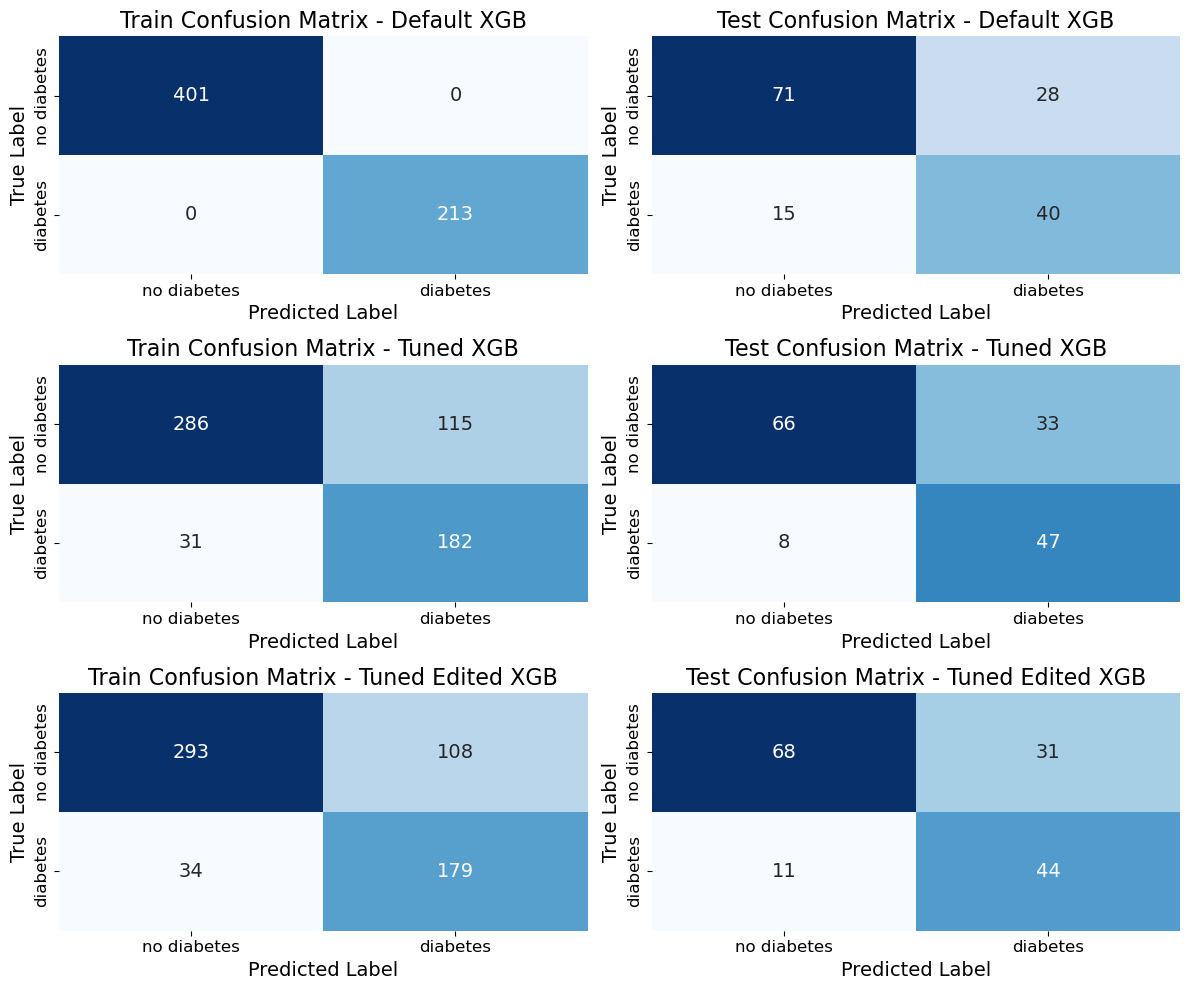

In [577]:
# confusion matrices

# calculate the confusion matrices
xgb_train = confusion_matrix(y_train,y_train_pred_xgb)
xgb_test = confusion_matrix(y_test,y_test_pred_xgb)

xgb_tuned_train = confusion_matrix(y_train,y_train_pred_xgb_gs)
xgb_tuned_test = confusion_matrix(y_test,y_test_pred_xgb_gs)

xgb_tuned2_train = confusion_matrix(y_train,y_train_pred_xgb2_gs)
xgb_tuned2_test = confusion_matrix(y_test,y_test_pred_xgb2_gs)

# set up the figure
fig,axes = plt.subplots(3,2,figsize=(12,10))

# a function to create a heatmap for the confusion matrices
def plot_cm(cm,ax,title):
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',ax=ax,cbar=False,
                xticklabels=['no diabetes','diabetes'],yticklabels=['no diabetes','diabetes'],
               annot_kws={'size':14})
    ax.set_xlabel('Predicted Label',fontsize=14)
    ax.set_ylabel('True Label',fontsize=14)
    ax.set_title(title,fontsize=16)
    ax.tick_params(axis='both',labelsize=12)

plot_cm(xgb_train,axes[0,0], 'Train Confusion Matrix - Default XGB')
plot_cm(xgb_test,axes[0,1], 'Test Confusion Matrix - Default XGB')

plot_cm(xgb_tuned_train,axes[1,0], 'Train Confusion Matrix - Tuned XGB')
plot_cm(xgb_tuned_test,axes[1,1], 'Test Confusion Matrix - Tuned XGB')

plot_cm(xgb_tuned2_train,axes[2,0], 'Train Confusion Matrix - Tuned Edited XGB')
plot_cm(xgb_tuned2_test,axes[2,1], 'Test Confusion Matrix - Tuned Edited XGB')

plt.tight_layout() 
plt.show()

The confusion matrices show/confirm that the XGB model fit to all features and tuned with a gridsearch of hyperparameters performs well on the train and test sets for having only a few false negatives.  However, this model also has a large number of false positives.  This may be a preferred model for ensuring that the majority of those likely to have T2DM are identified.  

## ROC curve

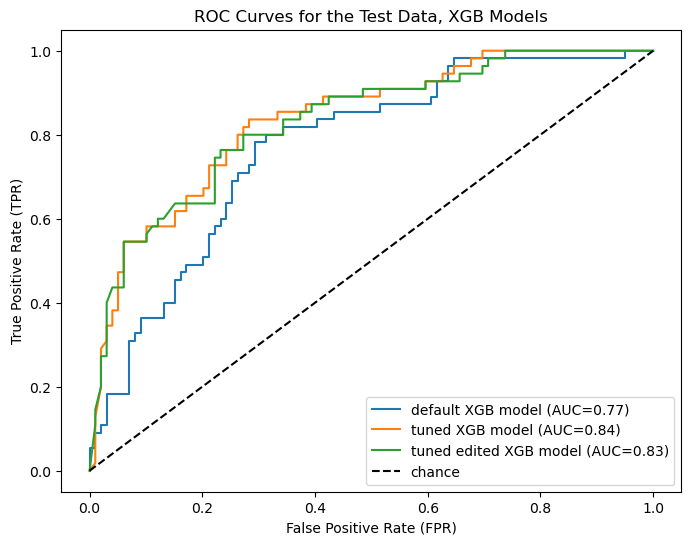

In [578]:
# ROC curves of the test data for three XGB models

fpr_xgb,tpr_xgb,_ = roc_curve(y_test,y_test_proba_xgb[:,1])
fpr_xgb_gs,tpr_xgb_gs,_ = roc_curve(y_test,y_test_proba_xgb_gs[:,1])
fpr_xgb2_gs,tpr_xgb2_gs,_ = roc_curve(y_test,y_test_proba_xgb2_gs[:,1])

# calculate the AUC scores
auc_xgb = roc_auc_score(y_test,y_test_proba_xgb[:,1])
auc_xgb_gs = roc_auc_score(y_test,y_test_proba_xgb_gs[:,1])
auc_xgb2_gs = roc_auc_score(y_test,y_test_proba_xgb2_gs[:,1])

plt.figure(figsize=(8,6))

plt.plot(fpr_xgb,tpr_xgb, label=f'default XGB model (AUC={auc_xgb:.2f})')
plt.plot(fpr_xgb_gs,tpr_xgb_gs, label=f'tuned XGB model (AUC={auc_xgb_gs:.2f})')
plt.plot(fpr_xgb2_gs,tpr_xgb2_gs, label=f'tuned edited XGB model (AUC={auc_xgb2_gs:.2f})')

# plot the chance line
plt.plot([0,1],[0,1], 'k--',label='chance')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.title('ROC Curves for the Test Data, XGB Models')

plt.show()

## Precision recall curve

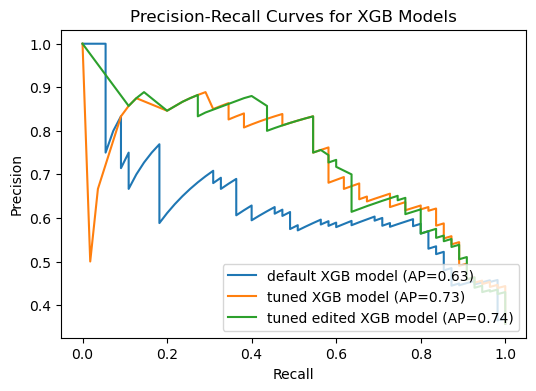

In [579]:
# precision recall curves of the test data for three XGB models

# get precision-recall values for each model
precision_xgb,recall_xgb,_ = precision_recall_curve(y_test,y_test_proba_xgb[:,1])
precision_xgb_gs,recall_xgb_gs,_ = precision_recall_curve(y_test,y_test_proba_xgb_gs[:,1])
precision_xgb2_gs,recall_xgb2_gs,_ = precision_recall_curve(y_test,y_test_proba_xgb2_gs[:,1])

# calculate the average precision (AP) scores for each model
ap_xgb = average_precision_score(y_test,y_test_proba_xgb[:,1])
ap_xgb_gs = average_precision_score(y_test,y_test_proba_xgb_gs[:,1])
ap_xgb2_gs = average_precision_score(y_test,y_test_proba_xgb2_gs[:,1])

# plot
plt.figure(figsize=(6,4))

plt.plot(recall_xgb,precision_xgb,label=f'default XGB model (AP={ap_xgb:.2f})')
plt.plot(recall_xgb_gs,precision_xgb_gs,label=f'tuned XGB model (AP={ap_xgb_gs:.2f})')
plt.plot(recall_xgb2_gs,precision_xgb2_gs,label=f'tuned edited XGB model (AP={ap_xgb2_gs:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for XGB Models')

plt.legend(loc='lower right')
plt.show()

The tuned model and the tuned edited model perform similarly.  The confusion matrix and AUC score gives a slight edge to the undedited version.  

## Calibrate Predicted Probabilities

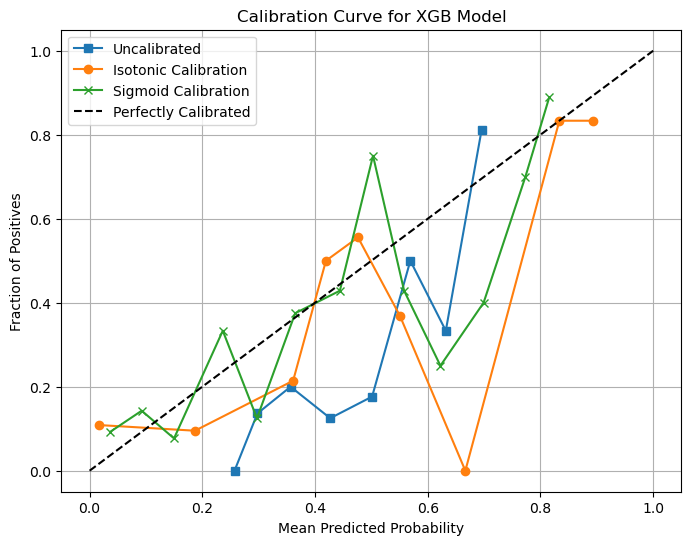

In [596]:
# the uncalibrated model has already been fit with GridsearchCV

# fit calibrated models with isotnic and sigmoid (Platt scaling) calibration
cal_isotonic_xgb = CalibratedClassifierCV(estimator=best_model_xgb,
                                        method='isotonic',cv='prefit')
cal_isotonic_xgb.fit(X_train,y_train)

cal_sigmoid_xgb = CalibratedClassifierCV(estimator=best_model_xgb,
                                        method='sigmoid',cv='prefit')
cal_sigmoid_xgb.fit(X_train,y_train)

# generate predicted probabilities
probs_uncalibrated_xgb = best_model_xgb.predict_proba(X_test)[:,1]
probs_isotonic_xgb = cal_isotonic_xgb.predict_proba(X_test)[:,1]
probs_sigmoid_xgb = cal_sigmoid_xgb.predict_proba(X_test)[:,1]

# compute calibration curves
prob_true_uncal_xgb, prob_pred_uncal_xgb = calibration_curve(y_test,probs_uncalibrated_xgb,n_bins=15)
prob_true_iso_xgb, prob_pred_iso_xgb = calibration_curve(y_test,probs_isotonic_xgb,n_bins=15)
prob_true_sig_xgb, prob_pred_sig_xgb = calibration_curve(y_test,probs_sigmoid_xgb,n_bins=15)

# plot the calibration curves
plt.figure(figsize=(8,6))
plt.plot(prob_pred_uncal_xgb,prob_true_uncal_xgb, 's-', label='Uncalibrated')
plt.plot(prob_pred_iso_xgb,prob_true_iso_xgb, 'o-', label='Isotonic Calibration')
plt.plot(prob_pred_sig_xgb,prob_true_sig_xgb, 'x-', label='Sigmoid Calibration')
plt.plot([0,1],[0,1], 'k--', label='Perfectly Calibrated')

plt.title('Calibration Curve for XGB Model')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend(loc='best')
plt.grid()
plt.show()

## Precision Recall Curve

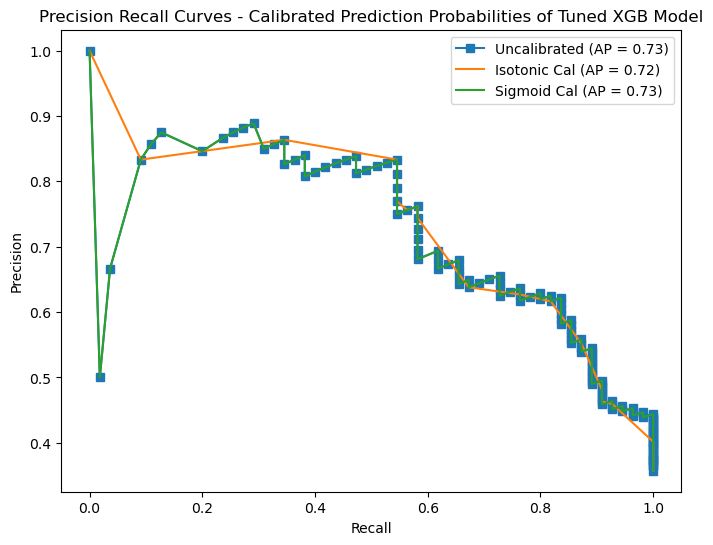

In [609]:
# calculate and plot precision recall curves on the calibrated predicition probabilities

precision_uncal_xgb, recall_uncal_xgb,_ = precision_recall_curve(y_test,probs_uncalibrated_xgb)
precision_iso_xgb, recall_iso_xgb,_ = precision_recall_curve(y_test,probs_isotonic_xgb)
precision_sigmoid_xgb, recall_sigmoid_xgb,_ = precision_recall_curve(y_test,probs_sigmoid_xgb)

# get average precision scores
ap_uncal_xgb = average_precision_score(y_test,probs_uncalibrated_xgb)
ap_iso_xgb = average_precision_score(y_test,probs_isotonic_xgb)
ap_sigmoid_xgb = average_precision_score(y_test,probs_sigmoid_xgb)

# plot the curve
plt.figure(figsize=(8,6))
plt.plot(recall_uncal_xgb,precision_uncal_xgb, 's-', label=f'Uncalibrated (AP = {ap_uncal_xgb:.2f})')
plt.plot(recall_iso_xgb,precision_iso_xgb, label=f'Isotonic Cal (AP = {ap_iso_xgb:.2f})')
plt.plot(recall_sigmoid_xgb,precision_sigmoid_xgb,label=f'Sigmoid Cal (AP = {ap_sigmoid_xgb:.2f})')

plt.title('Precision Recall Curves - Calibrated Prediction Probabilities of Tuned XGB Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')

plt.show()

## Classification Report

In [613]:
# generate the classification report on calibrated tuned XGB model predicted probabilities

y_pred_xgb_uncal = best_model_xgb.predict(X_test)
y_pred_xgb_isotonic = cal_isotonic_xgb.predict(X_test)
y_pred_xgb_sigmoid = cal_sigmoid_xgb.predict(X_test)

print('Classification Report - Calibrated Tuned XGB Model Predicted Probabilities')
print(f'\nTuned XGB Uncalibrated: \n{classification_report(y_test,y_pred_xgb_uncal)}')
print(f'\nTuned XGB Isotonic Calibrated: \n{classification_report(y_test,y_pred_xgb_isotonic)}')
print(f'\nTuned XGB Sigmoid Calibrated: \n{classification_report(y_test,y_pred_xgb_sigmoid)}')

Classification Report - Calibrated Tuned XGB Model Predicted Probabilities

Tuned XGB Uncalibrated: 
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        99
           1       0.59      0.85      0.70        55

    accuracy                           0.73       154
   macro avg       0.74      0.76      0.73       154
weighted avg       0.78      0.73      0.74       154


Tuned XGB Isotonic Calibrated: 
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        99
           1       0.64      0.67      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154


Tuned XGB Sigmoid Calibrated: 
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        99
           1       0.65      0.71      0.68        55

    accuracy    

Similar to the affect of calibrated random forest predicted probabilities, the calibrated XGB model predicted probabilities have higher precision scores but significantly lower recall scores on the minority class (1).

The calibrated predicted probabilities show less over-forecasting on the calibration curve plot, suggesting that the predicted probabilities are reduced and causing more false negative predictions for the minority class.  

Considering the saw-tooth shape of the calibration curves, it is possible that the model(s) are not fit properly.  However, the classification report metrics for both the random forest and XGB models show only low to moderate overfitting.  

## Brier & Log-Loss Scores

In [400]:
# calculate the baseline Brier score
p_majority = y_train.mean() # proportion of positive class in training set

baseline_brier_score = np.mean((p_majority - y_test) **2)

# calculate the baseline log-loss score
baseline_pred_proba = np.full_like(y_test,p_majority,dtype=float)
baseline_log_loss = log_loss(y_test,baseline_pred_proba)

# initialize models
pipelines = {
    'Logistic Regression':Pipeline(steps=[
    ('preprocessor',preprocessor_pipeline),
    ('lr',LogisticRegression(C=550,class_weight='balanced',max_iter=500,penalty='l1',
                             solver='liblinear',random_state=42
                            ))
    ]),

    'KNN':Pipeline(steps=[
    ('preprocessor',preprocessor_pipeline),
    ('knn',KNeighborsClassifier(algorithm='auto',leaf_size=3,metric='manhattan',n_neighbors=36,
                               weights='uniform'
                               ))
    ]),

    'Random Forest':Pipeline(steps=[
    ('preprocessor',preprocessor_pipeline),
    ('rf',RandomForestClassifier(bootstrap=True,class_weight='balanced_subsample',criterion='entropy',
                                 max_depth=5,max_features='sqrt',min_samples_leaf=3,min_samples_split=12,
                                 n_estimators=55,random_state=42
                                ))
    ]),

    'XGB':Pipeline(steps=[
    ('preprocessor',preprocessor_pipeline),
    ('xgb',XGBClassifier(colsample_bytree=0.7,gamma=0.3,learning_rate=0.04,max_depth=2,
                         min_child_weight=7,n_estimators=35,reg_alpha=0.6,reg_lambda=2,
                         scale_pos_weight=2,subsample=0.6,random_state=42
                        ))
    ]),

    'MLP':Pipeline(steps=[
    ('preprocessor',preprocessor_pipeline),
    ('mlp',MLPClassifier(activation='relu',alpha=1,hidden_layer_sizes=(7,),learning_rate='constant',
                         solver='adam',max_iter=1000,random_state=42
                        ))
    ])
}

# train and compute Brier scores
brier_scores = {}
log_loss_scores = {}

for name, pipeline in pipelines.items():
    pipeline.fit(X_train,y_train) # train the pipeline
    y_prob = pipeline.predict_proba(X_test)[:,1] # get probabilities for the positive class
    brier_scores[name] = brier_score_loss(y_test,y_prob)
    log_loss_scores[name] = log_loss(y_test,y_prob)

# print scores
print('Brier Scores')
print(f'Baseline Brier score: {baseline_brier_score:.4f}')
for model, score in brier_scores.items():
    print(f'{model}: {score:.4f}')
    
print()

print('Log-Loss Scores')
print(f'Baseline log-loss score: {baseline_log_loss:.4f}')
for model, score in log_loss_scores.items():
    print(f'{model}: {score:.4f}')

Brier Scores
Baseline Brier score: 0.2297
Logistic Regression: 0.1735
KNN: 0.1627
Random Forest: 0.1663
XGB: 0.1845
MLP: 0.1654

Log-Loss Scores
Baseline log-loss score: 0.6520
Logistic Regression: 0.5250
KNN: 0.4912
Random Forest: 0.4977
XGB: 0.5504
MLP: 0.4965


the KNN model had the lowest Brier and log-loss scores and, therefore, provides the most reliable prediction probabilities.  However, the KNN model has the lowest recall of the five models.  The XGB model has the highest Brier score and may need better hyperparameter tuning or possibly calibration of its predective probabilities.  